### Notes
This notebook was created as part of a project to predict which members of a not for profit orginizaiton will renew their membership and which will cancel.
Much of the code was adapted from https://machinelearningmastery.com/ 
some of the code including the upsampling and learning curves were taken form the machine learning with python github repo
various other resources also provided parts of the code.  The code was edited to hide all proprietary information.

### Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, make_scorer, f1_score, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split

### Import Data

In [2]:
data = pd.read_csv("format_variables_output4.csv")
#data.head()

In [4]:
# drop the entries for new members who joined leavig renewals and cancelations only
data = data[data['Target']!=2]

show the balance of the data set the renewal variable (1) has over 90% while cancelations are only 9.2%
This imbalance in the data set will be a challenge of this predicitive model.

In [5]:
data['Target'].value_counts(normalize=True)

1    0.907453
0    0.092547
Name: Target, dtype: float64

In [6]:
data.columns

Index(['Unnamed: 0', 'MemberName', 'NF_Year', 'ACS_Year', 'JoinDate',
       'ExpireDate', 'MemberStatus', 'State', 'StateName', 'StateCode',
       'Region', 'SummaryLevel', 'CombinedFips', 'Target', 'TotalPopulation',
       'MedianHouseholdIncome', 'MedianAge', 'NonHispanicWhites',
       'TotalWorkers', 'UseCar', 'PopOver25', 'Bachelors', 'Agriculture',
       'Construction', 'Manufacturing', 'WholesaleTrade', 'Retail',
       'Transportation', 'Information', 'Finance', 'Professional', 'Education',
       'Arts', 'OtherServices', 'PublicAdministration', 'ArmedForces',
       'Years as Member', '1', '10', '12', '13', '15', '16', '17', '18', '19',
       '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30',
       '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41',
       '42', '44', '45', '46', '47', '48', '49', '5', '50', '51', '53', '54',
       '55', '56', '6', '8', '9', 'Pop_Den', 'binned_pop_den',
       'MedianIncomeAdjusted', '%NonHispanicW

### Lets run a random Forest Model with some new variables including: Population density, years as member

In [3]:
data1 = data[['Target','TotalPopulation', 'MedianAge', 'MedianIncomeAdjusted', '%NonHispanicWhites',
            '%DrivetoWork','%Bachelors','Pop_Den','Years as Member']]

#data1.head()

In [8]:
target = 'Target'
X =  data1.drop(columns=['Target']).values
y = data1['Target'].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

After several experiments with different values for N to see if we can improve the model here are the results.  

In [15]:
rfc = RandomForestClassifier(n_estimators=30)
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)
print(confusion_matrix(y_test,rfc_pred))
print(classification_report(y_test,rfc_pred))

[[   9  397]
 [  15 3866]]
              precision    recall  f1-score   support

           0       0.38      0.02      0.04       406
           1       0.91      1.00      0.95      3881

    accuracy                           0.90      4287
   macro avg       0.64      0.51      0.50      4287
weighted avg       0.86      0.90      0.86      4287



In [16]:
rfc = RandomForestClassifier(n_estimators=2)
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)
print(confusion_matrix(y_test,rfc_pred))
print(classification_report(y_test,rfc_pred))

[[ 115  291]
 [ 606 3275]]
              precision    recall  f1-score   support

           0       0.16      0.28      0.20       406
           1       0.92      0.84      0.88      3881

    accuracy                           0.79      4287
   macro avg       0.54      0.56      0.54      4287
weighted avg       0.85      0.79      0.82      4287



The recall for cancellations was super low only 1-2%.  The last model with only 2 n estimators had better recall but much lower precision.  Lets try with only population density as a new variable. 

In [4]:
data1 = data[['Target','TotalPopulation', 'MedianAge', 'MedianIncomeAdjusted', '%NonHispanicWhites',
            '%DrivetoWork','%Bachelors','Pop_Den']]
# data1.head()

Lets try with different values of N like above and keep the best model.  

In [24]:
target = 'Target'
X =  data1.drop(columns=['Target']).values
y = data1['Target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)
print(confusion_matrix(y_test,rfc_pred))
print(classification_report(y_test,rfc_pred))

[[  19  387]
 [  15 3866]]
              precision    recall  f1-score   support

           0       0.56      0.05      0.09       406
           1       0.91      1.00      0.95      3881

    accuracy                           0.91      4287
   macro avg       0.73      0.52      0.52      4287
weighted avg       0.88      0.91      0.87      4287



In [25]:
rfc = RandomForestClassifier(n_estimators=2)
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)
print(confusion_matrix(y_test,rfc_pred))
print(classification_report(y_test,rfc_pred))

[[  95  311]
 [ 616 3265]]
              precision    recall  f1-score   support

           0       0.13      0.23      0.17       406
           1       0.91      0.84      0.88      3881

    accuracy                           0.78      4287
   macro avg       0.52      0.54      0.52      4287
weighted avg       0.84      0.78      0.81      4287



### Results with only 1 new variable were better than with years as member.  The f1 score for cancelations is improved from 1 or 2 to 9 with 50, 100 or 200 as values for N.   We will use population density as the only new variable.  

## Grid Search

The first grid search was run with scaled variables and balanced accuracy score as the scoring criteria.  The cross validation is 5 fold because these grid searches take over an hour.  

the best model had the following hyperparameters:
clf = RandomForestClassifier(n_estimators = 2, random_state = 0, min_samples_leaf=1, min_samples_split =2, criterion =  'entropy', max_depth= 40, max_features = 'auto', )

results were: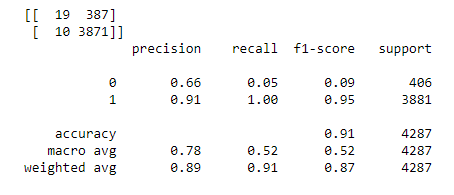


The results are simular to above.  More trees gives higher precision and less recall for cancelations.  I prefer more trees because with precison of 14% we are only slightly better than random (9%). For imbalanced data sets accuracy is a poor measure lets use area under roc curve as the scoring criteria.  

In [40]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [15]:
rf =  RandomForestClassifier()

param_grid = [{'n_estimators':  [2,50,100],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
              'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10, 20, 30, 40, 50, 60, 70, None],
    'criterion' :['gini', 'entropy']}]

gs = GridSearchCV(rf, param_grid=param_grid, scoring= 'roc_auc', cv=5, n_jobs=-1, verbose = 1)

gs = gs.fit(X_train, y_train)



print(gs.best_score_)
print(gs.best_params_)


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 38.6min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 50.2min
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed: 54.7min finished


0.6250568120525346
{'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


The best score had gone up from almost 55 to almost 63. Lets run the model with the  hyperparameters from the grid search.

In [46]:
clf = RandomForestClassifier(n_estimators = 100, random_state = 0, min_samples_leaf=2, min_samples_split =2, criterion =  'entropy', 
                             max_depth= None, max_features = 'log2', ).fit(X_train, y_train)

In [47]:
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(cm)
print(classification_report(y_test,y_pred))

[[  10  396]
 [   6 3875]]
              precision    recall  f1-score   support

           0       0.62      0.02      0.05       406
           1       0.91      1.00      0.95      3881

    accuracy                           0.91      4287
   macro avg       0.77      0.51      0.50      4287
weighted avg       0.88      0.91      0.87      4287



#### The precision is pretty good but recall is even worse than earlier.  

## learning curve

The curve is graphed based on the above model which was chosen from the grid search.  

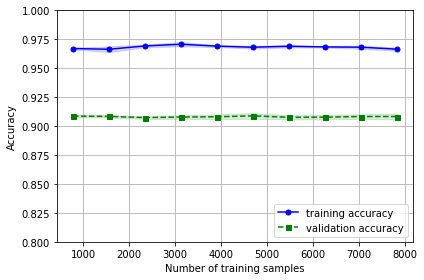

In [48]:
from sklearn.model_selection import learning_curve
    

# Plot Learning Curve
    # Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(n_estimators = 100, random_state = 0, min_samples_leaf=2, min_samples_split =2, criterion =  'entropy', 
                             max_depth= None, max_features = 'log2', ), 
                                            X_train,  y_train, cv=10, scoring='accuracy', n_jobs=-1, 
                                              train_sizes=np.linspace(0.1, 1.0, 10))



train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)



plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()

#### Results:
The learning curved was graphed several times with different hyperparameters with and without scaled variables.  The results were all simular to what is seen above.  The acuracy does not exceed 91% and adding more data doesn't seem to help.  91% accuracy is poor for an imblanced data set with 91% of the entries belonging to the majority class.  

### roc curve

Lets graph an roc curve with the  model to see how much predictive power the model has.

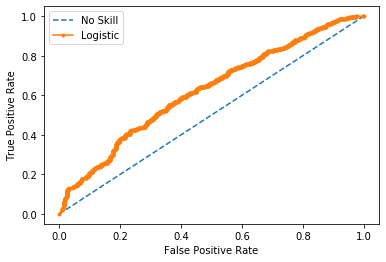

In [49]:
from sklearn.metrics import roc_curve

model = clf  # this is the model above from our grid search  
model.fit(X_train, y_train)
# predict probabilities
yhat = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic') # this is the wrong label disregard
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [50]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, model.predict(X_test)))

0.5115422742856127


From the roc graph it looks like the model did better than the logistic regression model but the auc score is lower and only a slight bit better than random.  The best model from the grid search got .62 which is higher than the logisitc regression model. 

RF: f1=0.951 auc=0.938


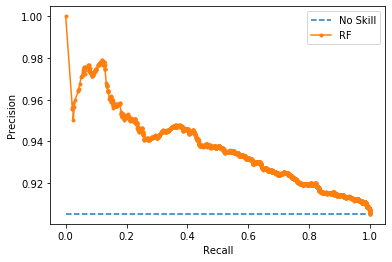

In [52]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

# predict probabilities
yhat = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# predict class values
y_pred = clf.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, yhat)
lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('RF: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='RF')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()

We can see the precision recall tradeoff.  Note the recall here is well above 90% but this includes the positives.  It does not tell us about recall for the minority class which is what we are most interested in.

# Imbalanced Classification 

Getting useful results from an imbalanced data set like this one can be challenging.  Different methodologies can be applied to ty and overcome this issue.  Lets try some of them.  The code and results for most methods tried was moved to a seperate notebook.


## Resample the data set to deal with class imbalance with upsampling

In [6]:
data1['Target'].value_counts()

1    11786
0     1202
Name: Target, dtype: int64

In [7]:
X_imb =  data1.drop(columns=['Target']).values
y_imb = data1['Target'].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_imb, y_imb , test_size=0.33, random_state=42)

The split was done before the upsample. The upsampling was done only on the training data not the testing data.

In [9]:
from sklearn.utils import resample

print('Number of class 0 samples before:', X_train[y_train == 0].shape[0])

X_upsampled, y_upsampled = resample(X_train[y_train == 0],
                                    y_train[y_train == 0],
                                    replace=True,
                                    n_samples=X_train[y_train == 1].shape[0],
                                    random_state=123)

print('Number of class 0 samples after:', X_upsampled.shape[0])

Number of class 0 samples before: 802
Number of class 0 samples after: 7899


In [10]:
# after increasing the number of cancelations the training data is merged with the renewals. 
X_train = np.vstack((X_train[y_train == 1], X_upsampled))
y_train = np.hstack((y_train[y_train == 1], y_upsampled))

In [11]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print(confusion_matrix(y_test,rfc_pred))
print(classification_report(y_test,rfc_pred))

[[  38  362]
 [  92 3795]]
              precision    recall  f1-score   support

           0       0.29      0.10      0.14       400
           1       0.91      0.98      0.94      3887

    accuracy                           0.89      4287
   macro avg       0.60      0.54      0.54      4287
weighted avg       0.86      0.89      0.87      4287



This gives us more balance between recall and precision but not a great model.  Lets try to tweak it.  

### Run a grid search combining upsampling with tuning 

The grid search was run with scalled data using area under roc curve as the scoring criteria.  5 fold cross validation was used becasue the searches are very slow.  

In [12]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [17]:
rf =  RandomForestClassifier()

param_grid = [{'n_estimators':  [2,50,100],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
              'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10, 20, 30, 40, 50, 60, 70, None],
    'criterion' :['gini', 'entropy']}]

gs = GridSearchCV(rf, param_grid=param_grid, scoring= 'roc_auc', cv=5, n_jobs=-1, verbose = 1)

gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 26.6min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 35.8min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 48.5min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 62.1min
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed: 67.4min finished


0.9996003605024567
{'criterion': 'entropy', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [19]:
gs.best_estimator_
grid_predictions = gs.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

[[  37  318]
 [ 105 3437]]
              precision    recall  f1-score   support

           0       0.26      0.10      0.15       355
           1       0.92      0.97      0.94      3542

    accuracy                           0.89      3897
   macro avg       0.59      0.54      0.55      3897
weighted avg       0.86      0.89      0.87      3897



Results are basically the same as the first model run with upsampling.  Note the best score from the grid search was really high.

## Learning Curve for upsampled data set

For criteria of scoring we will use f1 score.

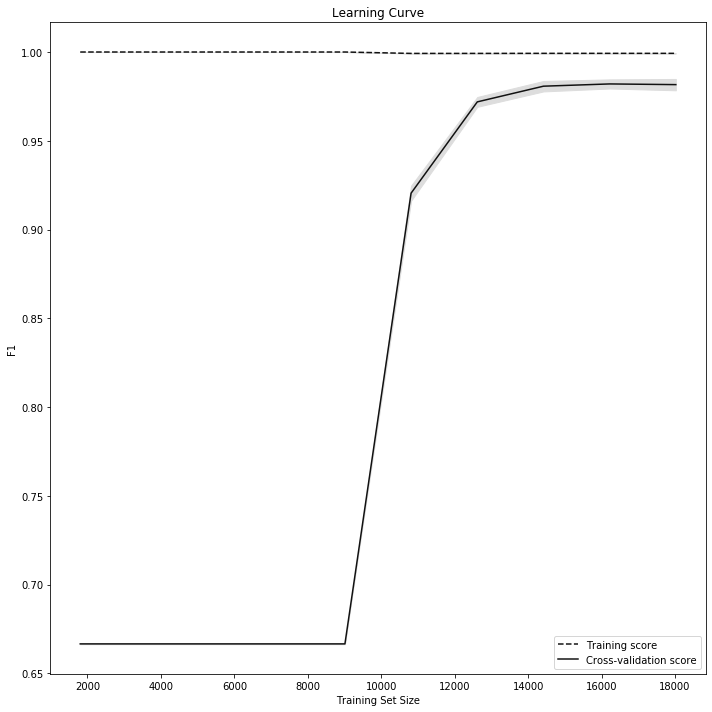

In [18]:
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(n_estimators = 50, random_state = 0,
                                min_samples_leaf=1, min_samples_split =2, criterion =  'entropy', 
                             max_depth= 60, max_features = 'log2', ), 
                                            X_train,  y_train, cv=10, scoring='f1', n_jobs=-1, 
                                              train_sizes=np.linspace(0.1, 1.0, 10))


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)



# Draw lines
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")
    
    # Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")
    
    # Create plot 
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("F1"), plt.legend(loc="best")
plt.tight_layout()


  We can see from the scale at the bottom the f1 score increases only once the training size gets to 9000 and doesn't level off until around 13k.  Lets see if we can generate an even bigger training set.

In [19]:
# test size is very small to leave a bigger training set
X_train, X_test, y_train, y_test = train_test_split(X_imb, y_imb , test_size=0.10, random_state=42)


print('Number of class 0 samples before:', X_train[y_train == 0].shape[0])

X_upsampled, y_upsampled = resample(X_train[y_train == 0],
                                    y_train[y_train == 0],
                                    replace=True,
                                    n_samples=X_train[y_train == 1].shape[0],
                                    random_state=123)

print('Number of class 0 samples after:', X_upsampled.shape[0])

X_train = np.vstack((X_train[y_train == 1], X_upsampled))
y_train = np.hstack((y_train[y_train == 1], y_upsampled))



from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

clf = RandomForestClassifier(n_estimators = 50, random_state = 0, min_samples_leaf=1, min_samples_split =2, criterion =  'entropy', 
                             max_depth= 60, max_features = 'log2', ).fit(X_train, y_train)

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(cm)
print(classification_report(y_test,y_pred))

Number of class 0 samples before: 1094
Number of class 0 samples after: 10595
[[  15   93]
 [  30 1161]]
              precision    recall  f1-score   support

           0       0.33      0.14      0.20       108
           1       0.93      0.97      0.95      1191

    accuracy                           0.91      1299
   macro avg       0.63      0.56      0.57      1299
weighted avg       0.88      0.91      0.89      1299



Things are improving.  The f1 score for the cancellations is rising and so is the recall.  
#### We only used a sample size of 10k cancellations including upsampled entries.  Maybe more data would help us.

the max n estimators tested in the grid search was 100 maybe more than that will help.

In [20]:
clf = RandomForestClassifier(n_estimators = 500, random_state = 0,
                                min_samples_leaf=1, min_samples_split =5, criterion =  'gini', 
                             max_depth= 50, max_features = 'log2', ).fit(X_train, y_train)



In [21]:
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(cm)
print(classification_report(y_test,y_pred))

[[  16   92]
 [  20 1171]]
              precision    recall  f1-score   support

           0       0.44      0.15      0.22       108
           1       0.93      0.98      0.95      1191

    accuracy                           0.91      1299
   macro avg       0.69      0.57      0.59      1299
weighted avg       0.89      0.91      0.89      1299



### Note for Later
This was the highest f1 score we were able to get so far for cancellations.  It is a random Forest model with n =500, upsampled with very large training set and scaled.  

#### roc curve
Lets graph an roc curve with the model to see how much predictive power the model has.

from sklearn.metrics import roc_curve

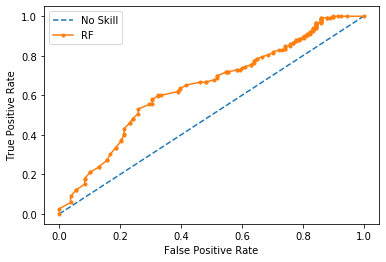

In [27]:
model = clf  # this is the model above where n = 500 
model.fit(X_train, y_train)
# predict probabilities
yhat = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='RF') 
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()


In [26]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, model.predict(X_test)))

0.5593688776938147


The auc Roc score is slightly better with this model than with other models.

A grid search using recall as criteria to optimize the recall was run and the best model was:
{'criterion': 'gini', 'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

The recall was very high but that is mainly because of the renwals.  For cancellations our recall has not improved at all (11%).  Below is a learning curve with recall as the scoring criteria.

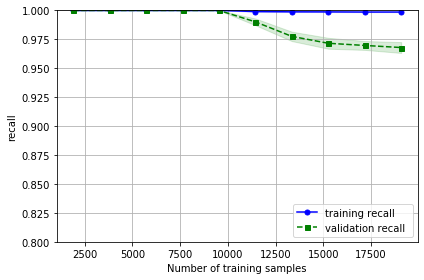

In [24]:
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(n_estimators = 100, random_state = 0,
                                min_samples_leaf=1, min_samples_split =5, criterion =  'gini', 
                             max_depth= 50, max_features = 'log2', ), 
                                            X_train,  y_train, cv=10, scoring='recall', n_jobs=-1, 
                                              train_sizes=np.linspace(0.1, 1.0, 10))


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)



plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training recall')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation recall ')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('recall')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()

In [59]:
# class balanced random forest for imbalanced classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# define model
model = RandomForestClassifier(n_estimators=100, class_weight='balanced')
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.617


In [60]:
model.fit(X_train, y_train) 


rfc_pred = model.predict(X_test)
print(confusion_matrix(y_test,rfc_pred))
print(classification_report(y_test,rfc_pred))

[[  21  385]
 [   9 3872]]
              precision    recall  f1-score   support

           0       0.70      0.05      0.10       406
           1       0.91      1.00      0.95      3881

    accuracy                           0.91      4287
   macro avg       0.80      0.52      0.52      4287
weighted avg       0.89      0.91      0.87      4287



### Result
The Roc score of .617 was lower than what was achieved above with smote and the default random Forest model.  However the precison was much better than with the unweighted models run earlier.  The recall is still pretty low with upsampling we were able to get it to 15%.  

# Adaboost

Sometimes different algorithms will help for an imbalanced data set.  Lets try boosting with adaboost which is simular to the Random Forest model.  

In [71]:
from sklearn.ensemble import AdaBoostClassifier

In [72]:
data = pd.read_csv("format_variables_output4.csv")
data = data[data['Target']!=2]

In [73]:
data1 = data[['Target','TotalPopulation', 'MedianAge', 'MedianIncomeAdjusted', '%NonHispanicWhites',
            '%DrivetoWork','%Bachelors','Pop_Den']]

In [75]:
target = 'Target'
X =  data1.drop(columns=['Target']).values
y = data1['Target'].values

In [76]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=4)


In [77]:
classifier = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200
)
classifier.fit(train_X, train_y)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [78]:
predictions = classifier.predict(test_X)

In [79]:
confusion_matrix(test_y, predictions)

array([[   5,  381],
       [   9, 3892]], dtype=int64)

In [80]:
print(classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

           0       0.07      0.00      0.00       406
           1       0.91      1.00      0.95      3881

    accuracy                           0.90      4287
   macro avg       0.49      0.50      0.48      4287
weighted avg       0.83      0.90      0.86      4287



tried with with less estimators and the results were simular.


 tried adaboost with upsampling and the results were improved on recall but precision was still only 10%.  With smote the precision was only 9%.  